In [ ]:
# !pip install -U tensorflow

In [18]:
import warnings
warnings.filterwarnings(action='ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import re

import src.useful_codes as uc

print(tf.__version__)

2.3.1


# Data
We will be building our twitter sentiment model using a dataset that contains 1.4 million tweets provided by Kaggle. If you wish to download the dataset, you can go to this <a href='https://www.kaggle.com/kazanova/sentiment140'>LINK</a> to access the dataset.

In [19]:
# importing data
columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
permanent = pd.read_csv('datasets/tweet_sentiments.csv',
                        encoding='latin', header=None)
permanent.columns = columns

In [20]:
permanent

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


Since we only care about the texts and their sentiments, we will drop other columns.

In [21]:
permanent = permanent[['sentiment', 'text']]

In [22]:
# Changes 0, 4 into categorical values: Negative and Positive
sentiment_dict = {0:'Negative', 4:'Positive'}
permanent['sentiment'] = permanent['sentiment'].apply(lambda x: sentiment_dict[x]);

[Text(0.5, 0, 'Sentiment'),
 Text(0, 0.5, 'Number of Tweets'),
 Text(0.5, 1.0, 'Sentiment Distribution')]

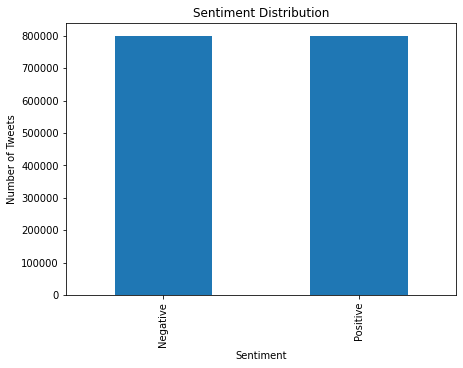

In [23]:
fig, ax = plt.subplots(figsize=(7,5))
permanent['sentiment'].value_counts().plot(kind='bar')
ax.set(xlabel='Sentiment', ylabel='Number of Tweets', title='Sentiment Distribution')

Lovely! No class imbalance!

In [47]:
# Define X and y
X = permanent['text']
y = permanent['sentiment']

# Splits test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.005, random_state=42)

# Splits traint set into train and validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.70, random_state=42)

In [36]:
# Initiates models
nb = MultinomialNB()
lr = LogisticRegression(solver='liblinear')

In [37]:
data = {'X': X_train, 'y': y_train}

In [38]:
tfidf = TfidfVectorizer(tokenizer=uc.clean_text,
                        ngram_range=(1,3),
                        max_features=2000,
                        min_df=5, max_df=0.2)

              precision    recall  f1-score   support

    Negative       0.75      0.76      0.75     20132
    Positive       0.75      0.75      0.75     19868

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000



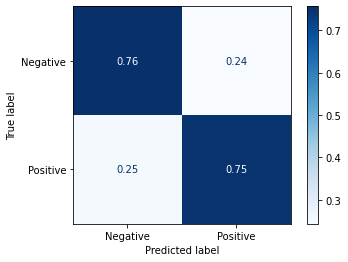

In [19]:
"""
tfidf = TfidfVectorizer(tokenizer=uc.clean_text,
                        ngram_range=(1,3),
                        max_features=2000,
                        min_df=5, max_df=0.2)
"""
nb_tfidf_model, report = uc.evaluate_binary_model(label='NB_lg_tfidf',
                                                  model='NB',
                                                  vectorizer=tfidf,
                                                  data=data)

In [20]:
report

{'label': 'NB_lg_tfidf',
 'run_time': 1703.390268087387,
 'train_row': 120000,
 'test_row': 40000,
 'total_row': 160000,
 'negative_recall': 0.7564573812835287,
 'positive_recall': 0.7486410308033018,
 'test_accuracy': 0.752575,
 'average_time': 0.01064618917554617}

In [46]:
uc.save_data(nb_tfidf_model, 'models/nb_tfidf_model')

In [47]:
uc.save_data(report, 'models/nb_tfidf_model_report')

In [40]:
binary_model = uc.load_data('models/nb_tfidf_model')

def prototype(model='binary'):
    user_input = input('Write a review: ')
    
#     text = get_clean_text(user_input)
#     word_emb = get_vector(text)
    if model=='binary':
        model = binary_model
    else:
        model = multiclass_word_emb
    print('-'*30)
#     print('Product: ', predict_product(text))
    print('Sentiment: ', predict_sentiment(model, user_input))
    print('Confidence: ', round(get_confidence(model, user_input)*100, 2), '%')
    print('-'*30)
    print('\n')
def get_clean_text(text):
    text = ' '.join(uc.clean_text(text))
    return text

def get_vector(text):
    word_emb = np.concatenate(uc.get_vec(text).reshape(-1,1), axis=0).reshape(-1, 300)
    return word_emb

def predict_sentiment(model, text):
    predict = model.predict([text])
    return predict[0]

def predict_product(text):
    predict = product_predictor.predict(text)
    return predict[0]

def get_confidence(model, text):
    prob = model.predict_proba([text])
    return max(prob[0])

In [12]:
while True:
    prototype()

Write a review: d
------------------------------
Sentiment:  Positive
Confidence:  50.08 %
------------------------------


Write a review: do it
------------------------------
Sentiment:  Positive
Confidence:  50.08 %
------------------------------


Write a review: love it
------------------------------
Sentiment:  Positive
Confidence:  76.9 %
------------------------------


Write a review: hate it
------------------------------
Sentiment:  Negative
Confidence:  86.47 %
------------------------------


Write a review: luvin it
------------------------------
Sentiment:  Positive
Confidence:  50.08 %
------------------------------


Write a review: luv
------------------------------
Sentiment:  Positive
Confidence:  72.2 %
------------------------------


Write a review: lov
------------------------------
Sentiment:  Positive
Confidence:  50.08 %
------------------------------


Write a review: love
------------------------------
Sentiment:  Positive
Confidence:  76.9 %
--------------

KeyboardInterrupt: 

In [16]:
from spacy import displacy

In [17]:
user_input = input('write text: ')
doc = nlp(user_input)
displacy.render(doc, style='ent', jupyter=True)

write text: this Iphone is amazing


In [45]:
nlp = spacy.load('en_core_web_lg')

In [49]:
X_train

1129267    @Juneya But I bet he likes them, maybe even ju...
210387     Just finished four hours of cleaning ... exhau...
33635                                back at work, booooooo 
27043      it would be much better if all my friends woul...
708669                                 Also: I am a fatass. 
                                 ...                        
259178     this song's middle change just doesn't want to...
1414414                 @officialnjonas Good luck with that 
131932              @ProudGamerTweet I rather average 32370 
671155     Pickin up @misstinayao waitin on @sadittysash ...
121958     @ home studying for maths wooot ! im so going ...
Name: text, Length: 8000, dtype: object

# Deep NLP

In [51]:
# Define X and y
X = permanent['text']
y = permanent['sentiment']

# Splits test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.005, random_state=42)

# Splits traint set into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.70, random_state=42)

In [55]:
X_train = pd.DataFrame(X_train)
X_train.columns = ['text']
X_train['clean'] = X_train['text'].apply(uc.clean_text)

In [56]:
X_train

,text,clean
993497,@EMarketingGuru I don't know my chocolate lab ...,"[not, know, chocolate, lab, lie, around, alot]"
580595,"focus, focus!! i cant....","[focus, focus, can, not, ....]"
917710,My favourite photo (that I took) from last nig...,"[favourite, photo, that, take, from, last, nig..."
414758,@twilightfairy I came back from Rohtang pass.I...,"[come, back, from, rohtang, pass, short, trip,..."
10785,rainy day clean house I guess...,"[rainy, day, clean, house, guess, ...]"
...,...,...
1538510,"@riptorn41 You're welcome, good luck with the ...","[you, welcome, good, luck, with, the, tech, su..."
1428127,@GLBriggs aw that's lovely,"[that, lovely]"
147032,just got home from makati http://plurk.com/p/...,"[just, get, home, from, makati]"
268246,sitting at my desk and wishing I was at home w...,"[sit, desk, and, wish, home, with, hubster]"


In [43]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

padded_shapes = ([None], ())

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(encoder.vocab_size, 64),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(dataset, epochs=5, validation_data=test_dataset,
          validation_steps=30)

In [58]:
!pip install ktrain

Could not fetch URL https://pypi.org/simple/ktrain/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/ktrain/ (Caused by SSLError(SSLError("bad handshake: SysCallError(32, 'EPIPE')",),)) - skipping
ERROR: Could not find a version that satisfies the requirement ktrain (from versions: none)
ERROR: No matching distribution found for ktrain
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLError("bad handshake: SysCallError(32, 'EPIPE')",),)) - skipping
